COGS 118B Final Project - Credit Risk Prediction with Hybrid Modeling

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import xgboost as xgb

In [36]:
# import dataset
app_df = pd.read_csv('datasets/application_record.csv')
credit_df = pd.read_csv('datasets/credit_record.csv')

# Drop FLAG_MOBIL column because it is a constant
print(app_df['FLAG_MOBIL'].value_counts())
app_df = app_df.drop("FLAG_MOBIL", axis=1)

FLAG_MOBIL
1    438557
Name: count, dtype: int64


In [37]:
# Data cleaning for classification
credit_df['STATUS'] = credit_df['STATUS'].replace('X', '-2')
credit_df['STATUS'] = credit_df['STATUS'].replace('C', '-1')
credit_df['STATUS'] = credit_df['STATUS'].astype(int)
credit_df['MONTHS_BALANCE'] = credit_df['MONTHS_BALANCE'].astype(int)

In [38]:
# generate a credit level label for each client based on credit history record
def two_classes(client):
    if client['STATUS'].max() <= 0:
        recent = client[client['MONTHS_BALANCE'] >= -6]
        if recent['STATUS'].max() <= 0:
            return 'Prime'
    return 'Subprime'

label_df_2 = credit_df.groupby('ID').apply(two_classes).to_frame()
label_df_2 = label_df_2.rename(columns={0: 'CLASS'})


def four_classes(client):
    recent = client[client['MONTHS_BALANCE'] >= -6]
    worst_status = client['STATUS'].max()
    worst_recent_status = recent['STATUS'].max()

    if worst_status < 0:
        if worst_recent_status < 0:
            return 'Super-prime'
    if worst_status <= 0:
        if worst_recent_status <= 0:
            return 'Prime'
    if worst_status <= 3:
        if worst_recent_status <= 1:
            return 'Near-prime'
    '''
    if worst_status <= 5:
        if worst_recent_status <= 3:
            return 'Subprime'
    '''
    return 'Subprime'
    
label_df_4 = credit_df.groupby('ID').apply(four_classes).to_frame()
label_df_4 = label_df_4.rename(columns={0: 'CLASS'})

/var/folders/sb/cdw7gr054nvc469rwn15_4q00000gn/T/ipykernel_56961/1480022293.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_df_2 = credit_df.groupby('ID').apply(two_classes).to_frame()
/var/folders/sb/cdw7gr054nvc469rwn15_4q00000gn/T/ipykernel_56961/1480022293.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_df_4 = credit_df.groupby('ID').apply(four_classes).to_frame()


In [39]:
# concat label to the application dataframe and change index to ID
label_app_df_2 = pd.merge(app_df, label_df_2, left_on='ID', right_index=True, how='inner')
label_app_df_2 = label_app_df_2.set_index('ID')

label_app_df_4 = pd.merge(app_df, label_df_4, left_on='ID', right_index=True, how='inner')
label_app_df_4 = label_app_df_4.set_index('ID')
label_app_df_4.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLASS
ID,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,Near-prime
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,Near-prime
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,Prime
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,Prime
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,Subprime


In [40]:
label_app_df_4['CLASS'].value_counts()

CLASS
Prime          20311
Subprime        9381
Super-prime     3706
Near-prime      3059
Name: count, dtype: int64

In [41]:
# Encode columns with string labels
df = label_app_df_2
str_columns = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", 
            "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "OCCUPATION_TYPE"]
for col in str_columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])


# Prepare trainning and testing data
X = df.drop("CLASS", axis=1)
y = df["CLASS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,0,0,18,2.0
5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,0,0,18,2.0
5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,0,0,0,16,2.0
5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,0,1,1,14,1.0
5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,0,1,1,14,1.0


In [59]:
# Feature selection function (choose top n features)
def feature_selection(X_train, X_test, n):
    selector = SelectKBest(score_func=f_classif, k=n)
    selector.fit(X_train, y_train)

    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    selected_mask = selector.get_support()
    features = X_train.columns[selected_mask]

    return X_train_selected, X_test_selected, features

# Choose the top 10 features
X_train_selected, X_test_selected, features = feature_selection(X_train, X_test, 10)
print(features)

Index(['FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS'],
      dtype='object')


1. Random Forest

In [43]:
# Run Random Forest
def run_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=2)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)

    return accuracy, report

rf_accuracy, rf_report = run_random_forest(X_train_selected, X_test_selected, y_train, y_test)

Accuracy: 0.6428963247394405
Classification Report:
              precision    recall  f1-score   support

       Prime       0.71      0.78      0.74      4820
    Subprime       0.47      0.38      0.42      2472

    accuracy                           0.64      7292
   macro avg       0.59      0.58      0.58      7292
weighted avg       0.63      0.64      0.63      7292



2. XGBoost Classifier

Accuracy: 0.6625068568294021
Classification Report:
              precision    recall  f1-score   support

           0       0.66      1.00      0.80      4820
           1       0.60      0.01      0.03      2472

    accuracy                           0.66      7292
   macro avg       0.63      0.50      0.41      7292
weighted avg       0.64      0.66      0.54      7292



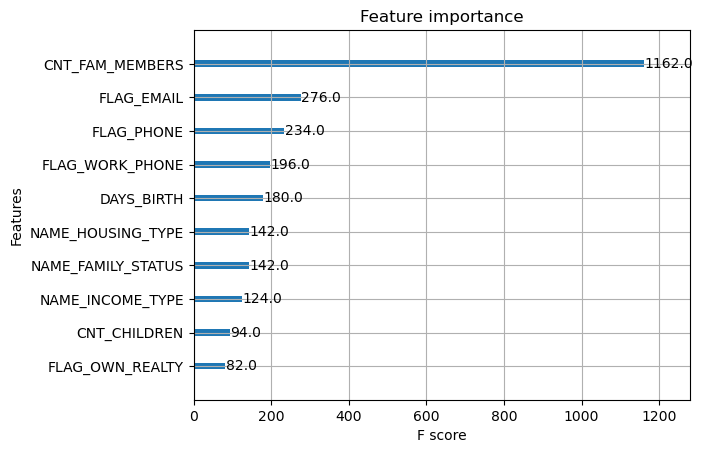

In [61]:
# Change the label to numerical for XGBoost

y_train_xgb = y_train.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 2, 'Near-prime':3})
y_test_xgb = y_test.map({'Prime': 0, 'Subprime': 1, 'Super-prime': 2, 'Near-prime':3})


# Run XGBoost
def run_xgboost(X_train, X_test, y_train, y_test, features):
    xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=2, max_depth=4, learning_rate=0.1, 
                                        n_estimators=100, random_state=2)
    xgb_classifier.fit(X_train, y_train)

    y_pred = xgb_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)
    
   
    xgb.plot_importance(xgb_classifier)
    plt.gca().set_yticklabels(features)
    plt.show()
    
    return accuracy, report

xgb_accuracy, xrb_report = run_xgboost(X_train_selected, X_test_selected, 
                                       y_train_xgb, y_test_xgb, features)